In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd

tf.get_logger().setLevel('ERROR')


c:\Users\victo\anaconda3\envs\aops_tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\victo\anaconda3\envs\aops_tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
I

# Create Dataset

In [2]:
def create_folder(path):
    try:
        os.makedirs(path)
        print(f"Folder --> '{path}' created")
    except FileExistsError:
        print(f"Already exist --> '{path}'")
        
def string_to_txt(path, file_name, string):
    if not file_name.endswith('.txt'):
        file_name += '.txt'
        
    file_path = f"{path}/{file_name}"

    with open(file_path, 'w') as file:
        file.write(string)


# import nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
class GeneralNLPPreprocessing:
    
    def remove_punctuation(self, text):
        # import string

        punctuations = string.punctuation  # !\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
        no_punct = "".join([char for char in text if char not in punctuations])
        return no_punct

    def remove_stopwords(self, text):
        # import nltk
        # from nltk.corpus import stopwords
        # nltk.download('stopwords')

        stop_words = stopwords.words('english')  # Get English stopwords
        words = text.split()  # Convert text to lowercase and split into words
        filtered_words = [word for word in words if word.lower() not in stop_words]  # Filter out stop words
        return " ".join(filtered_words)

    def lowercase(self, text):
        return text.lower()

    def stemming(self, text):
        # import nltk
        # from nltk.stem import PorterStemmer
        # nltk.download('punkt')

        stemmer = PorterStemmer()
        words = text.split()
        stemmed_words = [stemmer.stem(word, to_lowercase=False) for word in words]  # Apply stemming to each word
        return " ".join(stemmed_words)

    def lemmatize(self, text):
        import nltk
        from nltk.stem import WordNetLemmatizer
        from nltk.corpus import wordnet

        def get_wordnet_pos(treebank_tag):
            """
            Convert the part-of-speech naming scheme from Penn Treebank to WordNet.
            """
            if treebank_tag.startswith('J'):
                return wordnet.ADJ
            elif treebank_tag.startswith('V'):
                return wordnet.VERB
            elif treebank_tag.startswith('N'):
                return wordnet.NOUN
            elif treebank_tag.startswith('R'):
                return wordnet.ADV
            else:
                return wordnet.NOUN  # Default to noun if not found
        """
        Perform lemmatization on the input text.
        """
        lemmatizer = WordNetLemmatizer()
        tokens = nltk.word_tokenize(text)
        pos_tags = nltk.pos_tag(tokens)
        lemmatized_words = []
        for word, tag in pos_tags:
            pos = get_wordnet_pos(tag)
            lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
            lemmatized_words.append(lemmatized_word)
        return ' '.join(lemmatized_words)

    def fit(self, text):
        # text = self.remove_punctuation(text)
        text = self.remove_stopwords(text)
        # text = self.lowercase(text)
        text = self.stemming(text)
        # text = self.lemmatize(text)

        return text


import re
import html
import unicodedata
from bs4 import BeautifulSoup
class Preprocess:

    def decode_html_entities(self, text: str):
        """
        Decode HTML entities in a given text. Example:
            - &amp; --> &
            - &lt; --> <
            - &gt; --> >
            - &quot; --> "
            - &apos; --> '
            - etc.
        """
        # import html

        decoded_text = html.unescape(text)
        return str(decoded_text)

    def remove_html_tag_in_a_text(self, text: str):
        """
        Remove html tag in a text such as:
            - <br>
            - <span></span>
            - <b></b>
            - etc.
        """
        # from bs4 import BeautifulSoup

        clean_text = BeautifulSoup(text, 'html.parser').get_text()
        return str(clean_text)

    def remove_accented_characters(self, text: str):
        """
        Function replaces accented characters with their closest ASCII equivalents.
        In some cases, this may not be the desired behavior.
        For example, the character "ñ" would be replaced with "n".

        ÀáÉéÍíÓóÚúÑñ --> AaEeIiOoUuNn
        """
        # import unicodedata

        new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return str(new_text)

    def remove_redundant_white_spaces(self, text: str):
        # import re

        clean_text = re.sub(r'\s+', ' ', text).strip()
        return str(clean_text)

    def replace_img_tag_with_the_alt_attribute(self, html_text: str):
        """
        Before using this function, must perform:
            - `decode_html_entities()`
        """
        # from bs4 import BeautifulSoup

        soup = BeautifulSoup(html_text, 'html.parser')
        img_tags = soup.find_all('img')

        # Replace img tags with their alt attribute content
        for img_tag in img_tags:
            alt_text = img_tag.get('alt', '[MISSING_ALT]')  # Get alt attribute or [MISSING_ALT] string if missing
            img_tag.replace_with(alt_text)

        modified_text = str(soup)

        return modified_text

    def clean_text(self, text: str):
        text = text.replace("\n", " ")
        text = text.replace("\t", " ")
        text = text.replace("\r", " ")
        text = text.replace("\v", " ")
        return text

    def findall_occurrences_of_LaTex(self, text: str) -> list:
        """
        Find/capture all occurrences LaTex that indicated with `$ ... $` with an n number of `$`
        """
        # import re

        regex = re.compile(r'(\$+.*?\$+)')
        matches = re.findall(regex, text)  # Output: [$...$, $...$, ...]

        return matches

    def extract_inside_dollar_sign(self, text: str) -> str:
        """
        This function only for this specific input:
            - `$ 1/x \leq 10 $`  -->  ` 1/x \leq 10 `
            - `$1  anything z$`  -->  `1   anything z`  with the redundant spaces

        You can say this function remove suffix and prefix for `$` sign\n
        OR\n
        It takes/extracts text that flanked (diapit) with `$` sign
        """
        # import re

        regex = re.compile(r'\$+(.*?)\$+')
        result = re.findall(regex, text)
        return result[0]

    def fit(self, text: str):
        # text = self.remove_redundant_white_spaces(text)
        text = self.decode_html_entities(text)
        # text = self.remove_redundant_white_spaces(text)
        text = self.remove_accented_characters(text)
        # text = self.remove_redundant_white_spaces(text)
        text = self.clean_text(text)
        text = self.remove_redundant_white_spaces(text)
        text = self.replace_img_tag_with_the_alt_attribute(text)

        # text = self.remove_redundant_white_spaces(text)
        text = self.remove_html_tag_in_a_text(text)
        text = self.remove_redundant_white_spaces(text)

        text = text.replace("\[", "$")
        text = text.replace("\]", "$")

        captured_LaTex = self.findall_occurrences_of_LaTex(text)
        processed_LaTex = captured_LaTex.copy()
        for i in range(len(processed_LaTex)):
            processed_LaTex[i] = self.extract_inside_dollar_sign(processed_LaTex[i])

        for j in range(len(captured_LaTex)):
            text = text.replace(captured_LaTex[j], processed_LaTex[j])

        # text = GeneralNLPPreprocessing().fit(text)
        text = text.replace("\\", " ")
        text = self.remove_redundant_white_spaces(text)
        return text


In [3]:
df = pd.read_csv("../data/imo.csv")
df = df[df['label'].notna()]

# df['post_canonical'] = df['post_canonical'].apply(GeneralNLPPreprocessing().fit)
df['post_canonical'] = df['post_canonical'].apply(Preprocess().fit)


C:\Users\victo\AppData\Local\Temp\ipykernel_8924\1287750841.py:162: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, 'html.parser')
C:\Users\victo\AppData\Local\Temp\ipykernel_8924\1287750841.py:133: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_text = BeautifulSoup(text, 'html.parser').get_text()


In [4]:
from sklearn.model_selection import train_test_split

algebra = df[df['label'] == 'Algebra'][['id_key', 'post_canonical', 'label']]
combin = df[df['label'] == 'Combinatorics'][['id_key', 'post_canonical', 'label']]
geomet = df[df['label'] == 'Geometry'][['id_key', 'post_canonical', 'label']]
nt = df[df['label'] == 'Number Theory'][['id_key', 'post_canonical', 'label']]

m = min([algebra.shape[0], combin.shape[0], geomet.shape[0], nt.shape[0]])

algebra = algebra.sample(m, random_state=42)
combin = combin.sample(m, random_state=42)
geomet = geomet.sample(m, random_state=42)
nt = nt.sample(m, random_state=42)

algebra_combin_geomet_nt = [algebra, combin, geomet, nt]

create_folder("post_canonical")
create_folder("post_canonical/train")
create_folder("post_canonical/test")

for each in algebra_combin_geomet_nt:
    train, test = train_test_split(each, test_size=0.2, random_state=42)
    
    current_label = str(list(each['label'])[0])
    current_path_train, current_path_test = f"post_canonical/train/{current_label}", f"post_canonical/test/{current_label}"
    create_folder(current_path_train)
    create_folder(current_path_test)
    
    train = train.to_dict('records')
    for i in range(len(train)):
        id_key = str(train[i]['id_key'])
        string = train[i]['post_canonical']
        string_to_txt(
            path=current_path_train, 
            file_name=id_key, 
            string=string
        )

    test = test.to_dict('records')
    for j in range(len(test)):
        id_key = str(test[j]['id_key'])
        string = test[j]['post_canonical']
        string_to_txt(
            path=current_path_test, 
            file_name=id_key, 
            string=string
        )


Folder --> 'post_canonical' created
Folder --> 'post_canonical/train' created
Folder --> 'post_canonical/test' created
Folder --> 'post_canonical/train/Algebra' created
Folder --> 'post_canonical/test/Algebra' created
Folder --> 'post_canonical/train/Combinatorics' created
Folder --> 'post_canonical/test/Combinatorics' created
Folder --> 'post_canonical/train/Geometry' created
Folder --> 'post_canonical/test/Geometry' created
Folder --> 'post_canonical/train/Number Theory' created
Folder --> 'post_canonical/test/Number Theory' created


# Model

In [2]:
AUTOTUNE = tf.data.AUTOTUNE  # Output: -1 --> <class 'int'>
batch_size = 8
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'post_canonical/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)
class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'post_canonical/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'post_canonical/test',
    batch_size=batch_size
)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 2208 files belonging to 4 classes.
Using 1767 files for training.
Found 2208 files belonging to 4 classes.
Using 441 files for validation.
Found 552 files belonging to 4 classes.


In [3]:
# for text_batch, label_batch in train_ds.take(2):
#     for i in range(2):
#         print(f'Text: {text_batch.numpy()[i]}')
#         label = label_batch.numpy()[i]
#         print(f'Label : {label} ({class_names[label]})')


In [4]:
# bert_model_name = ""
# tfhub_handle_encoder = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-4-h-768-a-12/versions/2"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/2"
tfhub_handle_preprocess = "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"

bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/2
Preprocess model auto-selected: https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3


In [5]:
text_test = ['A social network has 2019 users, some pairs of whom are friends. Whenever user A is friends with user B, user B is also friends with user A. Events of the following kind may happen repeatedly, one at a time: Three users A, B, and C such that A is friends with both B and C, but B and C are not friends, change their friendship statuses such that B and C are now friends, but A is no longer friends with B, and no longer friends with C. All other friendship statuses are unchanged. Initially, 1010 users have 1009 friends each, and 1009 users have 1010 friends each. Prove that there exists a sequence of such events after which each user is friends with at most one other user. Proposed by Adrian Beker, Croatia']
# text_test = ['x^2']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :10]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :10]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :10]}')


Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  1037  2591  2897  2038 10476  5198  1010  2070  7689]
Input Mask : [1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0]


In [6]:
# bert_results = bert_model(text_preprocessed)

# print(f'Loaded BERT: {(tfhub_handle_encoder)}\n')
# print(f'Keys: {list(bert_results.keys())}')
# print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')


In [7]:
def build_classifier_model(tfhub_preprocess, tfhub_encoder):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(tfhub_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    
    encoder = hub.KerasLayer(tfhub_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)  # Additional dense layer
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)  # Additional dense layer
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
    
    return tf.keras.Model(text_input, net)


In [8]:
# Create a StringLookup layer to map string labels to integer indices
label_processor = tf.keras.layers.StringLookup(
    vocabulary=['Algebra', 'Combinatorics', 'Geometry', 'Number Theory'],
    mask_token=None  # Treats unknown tokens as missing values
)

# Map string labels to integer indices
train_labels = train_ds.map(lambda text, label: label_processor(label))
val_labels = val_ds.map(lambda text, label: label_processor(label))
test_labels = test_ds.map(lambda text, label: label_processor(label))


In [12]:
classifier_model = build_classifier_model(tfhub_preprocess=tfhub_handle_preprocess, tfhub_encoder=tfhub_handle_encoder)

epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
optimizer = optimization.create_optimizer(
    init_lr=1e-4,
    num_train_steps=num_train_steps,
    num_warmup_steps=int(0.1*num_train_steps),
    optimizer_type='adamw')
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

loss = tf.keras.losses.sparse_categorical_crossentropy  # Assuming you have integer labels
metrics = ['accuracy']

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))


In [13]:
history = classifier_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs
    )


Epoch 1/3


221/221 [==============================] - 51s 203ms/step - loss: 0.7543 - accuracy: 0.7119 - val_loss: 0.3741 - val_accuracy: 0.8753
Epoch 2/3
221/221 [==============================] - 45s 203ms/step - loss: 0.3731 - accuracy: 0.8902 - val_loss: 0.4565 - val_accuracy: 0.8866
Epoch 3/3
221/221 [==============================] - 45s 204ms/step - loss: 0.2262 - accuracy: 0.9423 - val_loss: 0.5176 - val_accuracy: 0.8980


In [38]:
classifier_model.predict(tf.constant(["Find all real functions f defined on mathbb R, such that f(f(x)+y) = f(f(x)-y)+4f(x)y ,for all real numbers x,y."]))

1/1 [==============================] - 0s 38ms/step


array([[9.9915266e-01, 1.8473837e-04, 3.7815607e-05, 6.2481739e-04]],
      dtype=float32)

In [32]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


69/69 [==============================] - 5s 61ms/step - loss: 0.4952 - accuracy: 0.8768
Loss: 0.49515554308891296
Accuracy: 0.8768116235733032


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


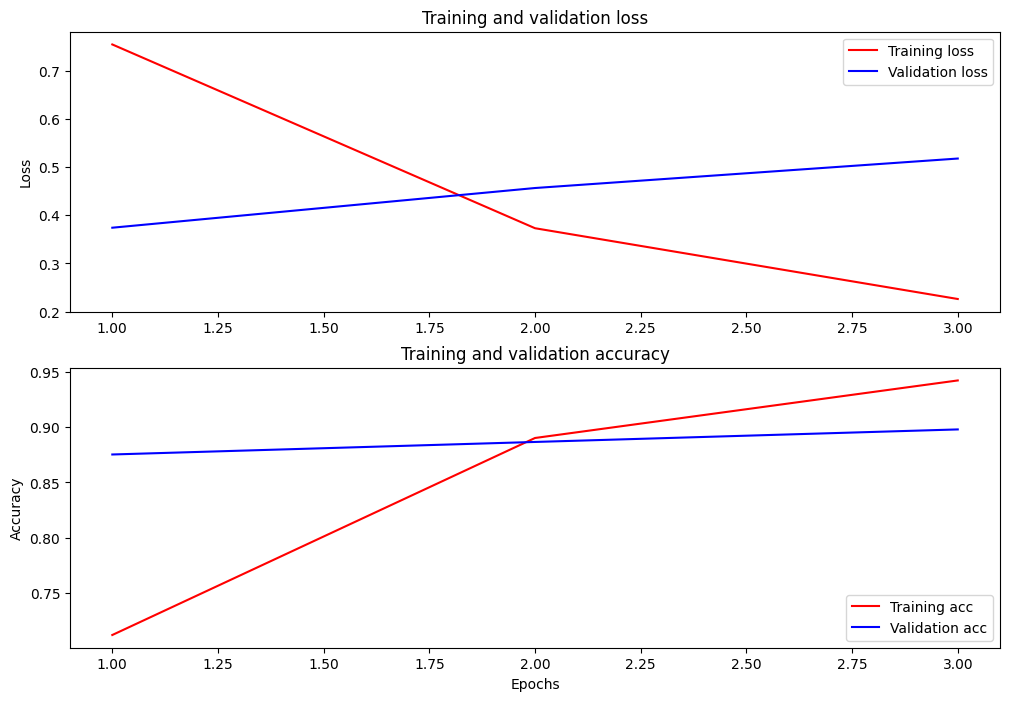

In [36]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
